<a href="https://colab.research.google.com/github/LindsClar/Real_Estate_Rep/blob/main/Predicting_CA_Property_Through_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting CA Property Through Modeling

# How I'll be approaching the data:

The data contains all the sales documented on Zillow from 2018 to 2024 for every state in the United States.

I'll be cleaning the data then narrowing the data to only California.

The plan is to load the data, organize the data, split the data and model the data.



Hypothesis: I believe that the best modelling for the predictive cariable Homevalues in San Diego, CA would be ARIMA.





---



# Import the *Libraries*

In [1]:
#import packages normal packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from xgboost import plot_tree
import xgboost as xgb
from xgboost import XGBRegressor

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.linear_model import Lasso
#import library
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot

from sklearn.ensemble import RandomForestRegressor
#importing libraries for modeling XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree

from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score



---



# Loading the Data

In [2]:
#read CSV files
df = pd.read_csv('/content/USRealEstateTrends.csv')

In [3]:
#Analyze information
df.head()

,RegionID,SizeRank,RegionName,StateName,2018-02-HomeValue,2018-02-DaysPending,2018-02-CutRaw,2018-03-HomeValue,2018-03-DaysPending,2018-03-CutRaw,...,2024-02-CutRaw,2024-03-HomeValue,2024-03-DaysPending,2024-03-CutRaw,2024-04-HomeValue,2024-04-DaysPending,2024-04-CutRaw,2024-05-HomeValue,2024-05-DaysPending,2024-05-CutRaw
0,102001,0,United States,NaN,225746.614318,52.0,7600.0,227155.648994,48.0,8900.0,...,10000.0,357374.362080,42.0,10000.0,359240.114070,38.0,10000.0,360681.294250,37.0,10000.0
1,394913,1,"New York, NY",NY,468313.430126,68.0,16000.0,470102.249154,63.0,19751.5,...,25000.0,646508.747102,55.0,25000.0,652619.099940,51.0,26000.0,657279.223513,47.0,30000.0
2,753899,2,"Los Angeles, CA",CA,629019.165765,33.0,20000.0,636850.139417,31.0,20000.0,...,30000.5,952665.578913,32.0,34000.0,956266.687926,29.0,40012.0,962388.491425,28.0,40000.0
3,394463,3,"Chicago, IL",IL,229741.266973,52.0,8000.0,231317.183706,42.0,9100.0,...,10000.0,316875.294320,29.0,10000.0,319764.144323,25.0,10000.0,321897.252361,23.0,10000.0
4,394514,4,"Dallas, TX",TX,241533.231800,46.0,8562.0,243401.180622,42.0,9900.0,...,10000.0,379972.349667,42.0,10000.0,380957.392395,38.0,10000.0,381103.625851,38.0,10000.0




---



# Evaluating and Organizing the Data

In [4]:
#clean/fill missing data
#rename column name
df.rename(index=str, columns={'RegionName' : 'Location', 'StateName':'State'}, inplace=True)

#dropping the not needed
df.dropna(inplace=True)

#identifying missing values
df.isna().sum()

,0
RegionID,0
SizeRank,0
Location,0
State,0
2018-02-HomeValue,0
...,...
2024-04-DaysPending,0
2024-04-CutRaw,0
2024-05-HomeValue,0
2024-05-DaysPending,0


In [5]:
#Melting Data - melted data allows you to split the dataset by time
df_melt=pd.melt(df, id_vars=['RegionID','SizeRank','Location','State',], var_name='Year_Month_Parameters', value_name='Values')

df_melt[['Year', 'Month_Parameters']] = df_melt['Year_Month_Parameters'].str.split('-', expand=True, n=1)
df_melt.drop('Year_Month_Parameters', axis=1, inplace=True)

#Organize so melted DF shows a column of month
df_melt[['Month', 'Parameters']] = df_melt['Month_Parameters'].str.split('-', expand=True, n=1)
df_melt.drop(columns = ['Month_Parameters'], inplace=True)

df_melt.head()


,RegionID,SizeRank,Location,State,Values,Year,Month,Parameters
0,394913,1,"New York, NY",NY,468313.430126,2018,02,HomeValue
1,753899,2,"Los Angeles, CA",CA,629019.165765,2018,02,HomeValue
2,394463,3,"Chicago, IL",IL,229741.266973,2018,02,HomeValue
3,394514,4,"Dallas, TX",TX,241533.231800,2018,02,HomeValue
4,394692,5,"Houston, TX",TX,208651.872272,2018,02,HomeValue


In [6]:
# Pivot the DataFrame to have measures as columns
df_reorganized = df_melt.pivot_table(index=['RegionID','SizeRank','Location','State','Year','Month'], columns='Parameters', values='Values').reset_index()
df_reorganized.head(5)

Parameters,RegionID,SizeRank,Location,State,Year,Month,CutRaw,DaysPending,HomeValue
0,394308,64,"Albany, NY",NY,2018,02,5100.0,64.0,218876.519605
1,394308,64,"Albany, NY",NY,2018,03,7000.0,62.0,219792.863791
2,394308,64,"Albany, NY",NY,2018,04,8000.0,54.0,220505.058669
3,394308,64,"Albany, NY",NY,2018,05,9000.0,45.0,221526.705984
4,394308,64,"Albany, NY",NY,2018,06,9100.0,47.0,222479.931387


In [7]:
#focus to CA  - filter the DF
CA = df_reorganized.loc[df_reorganized['State']=='CA']

In [8]:
#Correcting time
CA['Date'] = pd.to_datetime(CA['Year'].astype(str) + '-' + CA['Month'].astype(str))
print(CA['Date'].head())

304   2018-02-01
305   2018-03-01
306   2018-04-01
307   2018-05-01
308   2018-06-01
Name: Date, dtype: datetime64[ns]


<ipython-input-8-870d248f46d4>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  CA['Date'] = pd.to_datetime(CA['Year'].astype(str) + '-' + CA['Month'].astype(str))
<ipython-input-8-870d248f46d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA['Date'] = pd.to_datetime(CA['Year'].astype(str) + '-' + CA['Month'].astype(str))


In [9]:
CA.head()

Parameters,RegionID,SizeRank,Location,State,Year,Month,CutRaw,DaysPending,HomeValue,Date
304,394357,63,"Bakersfield, CA",CA,2018,02,7000.0,51.0,212531.666950,2018-02-01
305,394357,63,"Bakersfield, CA",CA,2018,03,7100.0,48.0,213905.260766,2018-03-01
306,394357,63,"Bakersfield, CA",CA,2018,04,6000.0,46.0,214996.109254,2018-04-01
307,394357,63,"Bakersfield, CA",CA,2018,05,7600.0,47.0,216057.814209,2018-05-01
308,394357,63,"Bakersfield, CA",CA,2018,06,8000.0,48.0,217117.256125,2018-06-01


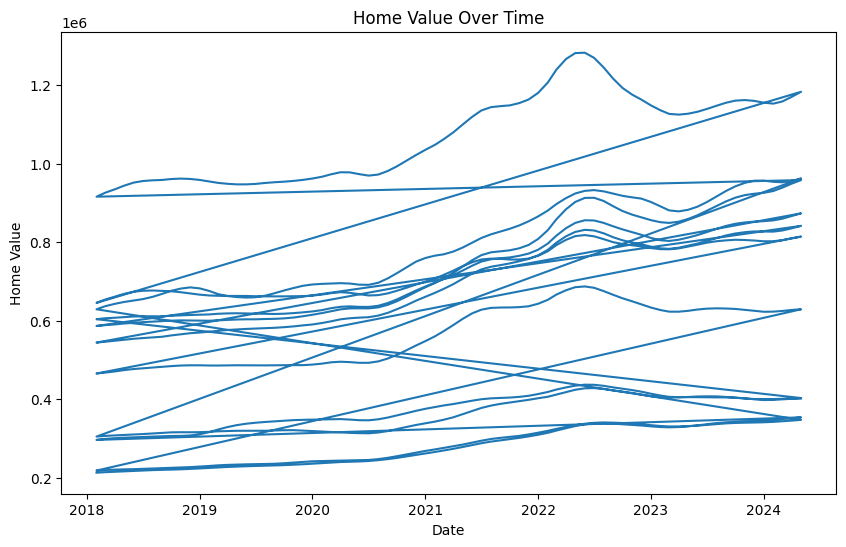

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(CA['Date'], CA['HomeValue'])
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.title('Home Value Over Time')
plt.show()
#plt.scatter(CA['Date'], CA['HomeValue'])


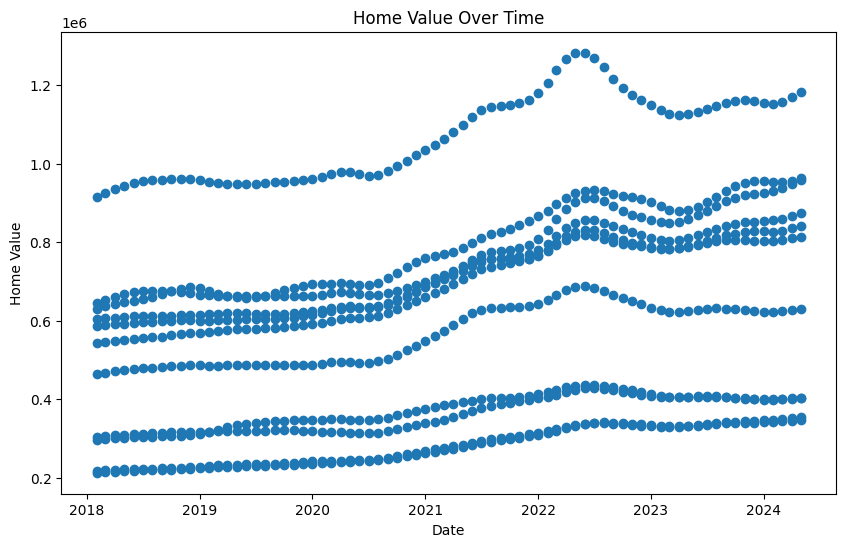

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(CA['Date'], CA['HomeValue'])
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.title('Home Value Over Time')
plt.show()
#plt.scatter(CA['Date'], CA['HomeValue'])

In [12]:
#Locating the # of unique values
CA["Location"].nunique()
CA["Location"].unique()

array(['Bakersfield, CA', 'Chico, CA', 'Oxnard, CA', 'Salinas, CA',
       'San Diego, CA', 'San Francisco, CA', 'Santa Rosa, CA',
       'Truckee, CA', 'Visalia, CA', 'Los Angeles, CA', 'Sonora, CA'],
      dtype=object)

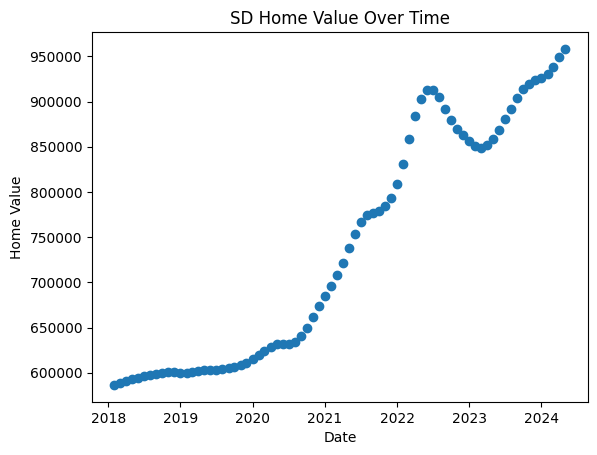

In [13]:
#Focusing on one city homevalues that were consistly recoreded for the State of CA
CA_SD = CA[CA['Location']=='San Diego, CA']

plt.scatter(CA_SD['Date'], CA_SD['HomeValue'])
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.title('SD Home Value Over Time')
plt.show()

Data Preparation for Linear Regression
  - best fit curve or line representing the relationship between these two variables. If the relation between dependent variable and independent variable is a straight line or establishing a linear relationship

In [14]:
CA_SD.info()

CA_SD['Date'] = CA_SD['Date'].map(pd.Timestamp.toordinal)

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 6916 to 6991
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RegionID     76 non-null     int64         
 1   SizeRank     76 non-null     int64         
 2   Location     76 non-null     object        
 3   State        76 non-null     object        
 4   Year         76 non-null     object        
 5   Month        76 non-null     object        
 6   CutRaw       76 non-null     float64       
 7   DaysPending  76 non-null     float64       
 8   HomeValue    76 non-null     float64       
 9   Date         76 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 6.5+ KB


<ipython-input-14-72ef459dbd8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_SD['Date'] = CA_SD['Date'].map(pd.Timestamp.toordinal)




---



# Splitting the Data

In [15]:
#defining X and y

X = CA_SD[['Date']]
y = CA_SD['HomeValue']

In [16]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=False)



---



# Modeling
 Now we'll be testing and implimenting different models to inspect home value increate.



# 1. Linear Regression

In [17]:
clf = LinearRegression()

In [18]:
clf.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = clf.predict(X_test)

In [20]:
y_test.head()

,HomeValue
6969,913153.036869
6970,904947.747440
6971,891490.618975
6972,879394.082138
6973,870207.266855


In [21]:
clf.score(X_test, y_test)

0.02507934596610384

This demonstates a really low predictive accuracy using linear Regression, despite the the low accuracy I will still be plotting the linear regression model.

In [22]:
print(f'This is the R2 Score : {clf.score(X_test, y_test)}')

This is the R2 Score : 0.02507934596610384


In [23]:
#import to mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'This is the root of the Mean Squared Error : {rmse}')

This is the root of the Mean Squared Error : 32419.459238149804


In [24]:
#r2
r2 = r2_score(y_test, y_pred)
print(f'This is the R2 Score : {r2}')

This is the R2 Score : 0.02507934596610384


In [25]:
#testing the length before plotting the data
print(len(X_test), len(y_test), len(y_pred))

23 23 23


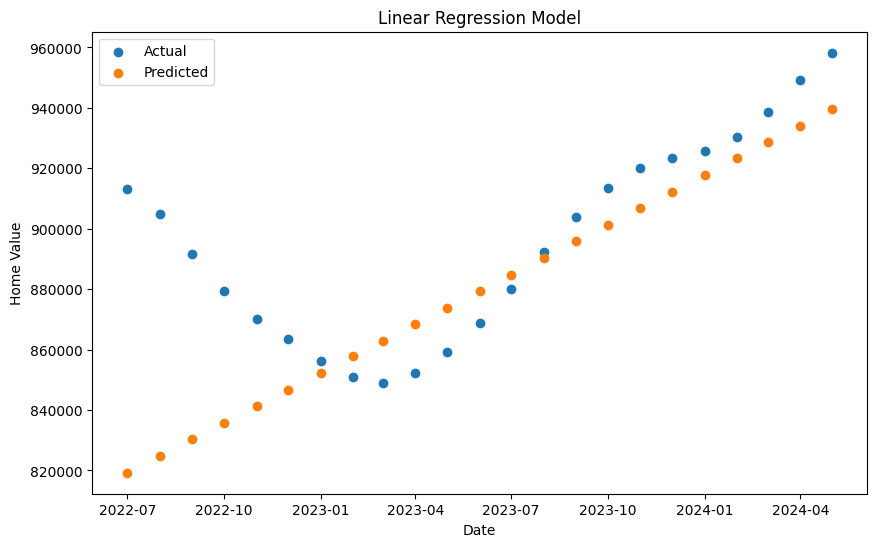

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.map(pd.Timestamp.fromordinal), y_test)
plt.scatter(X_test.map(pd.Timestamp.fromordinal), y_pred)
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.title('Linear Regression Model')
plt.legend(['Actual', 'Predicted'])
plt.show()

Now we'll be looking at the extensions of linear regression:
  - Ridge Regression
    - Normally used to correct for overfitting on training data. The idea is with a slightly worse fit it can allow for better predeictions.
      - https://www.youtube.com/watch?v=Q81RR3yKn30
  - Lasso Regression
    - Fairly similar to RR but the difference is LR can get the slope shrinked to 0 and this assissts to predict size. This eliminates features that aren't important and identifies the most important variables.
      - https://www.youtube.com/watch?v=NGf0voTMlcs
  - Elastic Net
    - Removes unneccessary variables, plus uses both lasso and Ridge Regression
      - https://www.youtube.com/watch?v=1dKRdX9bfIo

With this analysis of each extension of linear regression, I'm inclined to focus on lasso regressio because it shinks all the extra variables away to focus soley on the one variable in the training/test data.


In [27]:
lasso = Lasso()

In [28]:
lasso.fit(X_train, y_train)

Lasso()

In [29]:
y_pred_lasso = lasso.predict(X_test)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print("Lasso Regression Mean Absolute Error:", mae_lasso)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression Mean Squared Error:", mse_lasso)

r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression R2 Score:", r2_lasso)

Lasso Regression Mean Absolute Error: 21760.445238586253
Lasso Regression Mean Squared Error: 1051021480.9677964
Lasso Regression R2 Score: 0.02507921269526392


Lasso Regression Analysis:

  - MAE shows a deviation of 21,760 units with indicates a lard # of errors
  - MSE indications that there avg of the squared difference between prediction and values that we document
  - r^2 shows that there is a 2.50% variance in target variable. With r^2 close to 0 it would indicatethat the

In [30]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, .1, 1, 10, 100, 1000]
}
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [31]:
y_pred_lasso_cv = lasso_cv.predict(X_test)

mae_lasso_cv = mean_absolute_error(y_test, y_pred_lasso_cv)
print("Lasso Regression CV Mean Absolute Error:", mae_lasso_cv)

mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
print("Lasso Regression CV Mean Squared Error:", mse_lasso_cv)

r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)
print("Lasso Regression CV R2 Score:", r2_lasso_cv)

Lasso Regression CV Mean Absolute Error: 21763.103482213904
Lasso Regression CV Mean Squared Error: 1051165040.4004929
Lasso Regression CV R2 Score: 0.024946047885900935


The results of Lasso Regression with Cross Validation
  - MAE shows a deviation of 21,763 units with indicates a lard # of errors
  - MSE indications that there avg of the squared difference between prediction and values that we document
  - r^2 shows that there is a 2.49% variance in target variable. With r^2 close to 0 it would indicatethat the

  

In [32]:
lasso_cv.best_estimator_

Lasso(alpha=1000)

In [33]:
#Used indication from best estimator above to determine alpha perameter

lasso_3 = Lasso(alpha=1000)
lasso_3.fit(X_train, y_train)

Lasso(alpha=1000)

Now I'll be checking the intercept term of the linear equation. This will also provide important information on the baseline of the value of the variable and will assist in understanding the relationship between the predictor vs response variable.

In [34]:
lasso_3.intercept_

-131729460.41523717

The intercept value of −131729460.41 indicates a negative bias in the model's baseline prediction. This could be influenced by the singular variable, HomeValue in San Diego, which the model is focused on.

The model isn't accurate in the representation of the relationship between the predictor and response.

Now we use, .coef of Lasso_3, this is to see the slope associated with the feature which is the singular predictor.

In [35]:
lasso_3.coef_

array([179.52329325])

The value 179.52 shows that when the unit increases the predicted variable increases by 179.52.

After initially exploring the modeling of Linear Regression, I decided to examine its performance further by incorporating hyperparameter tuning. Specifically, I evaluated various regularization techniques, including Ridge Regression, Lasso Regression, and Elastic Net.


After careful consideration, I chose to focus on Lasso Regression for hyperparameter tuning of Linear Regression. However, the results are not promising. The modeling and associated error rates indicate that the performance is suboptimal, suggesting potential issues in the approach or the data itself.



---



# 2. ARIMA

Autoregressive Integrated Moving Average


  - This model uses historical data to forecast for future values and it doesn't take into account external features, such as natural disasters.


An autocorrelation plot (ACF plot) shows how values in a time series relate to past values, or “lags.” The x-axis represents these lags (lag 1, lag 2, etc.), while the y-axis shows the correlation strength, ranging from -1 to 1. Points near 1 or -1 indicate a strong relationship with past values, while values near 0 suggest no relationship. Confidence bands (horizontal dashed lines) mark the range where random noise is expected; points outside these bands indicate meaningful correlations for those lags.
Interpreting the ACF plot helps you detect patterns like trends or seasonality. If correlations decline gradually over lags, it suggests a trend, meaning past values have a lasting impact. Peaks at regular intervals indicate seasonality, as in monthly data showing yearly cycles. A single, significant spike at lag 1 that quickly fades suggests a simple dependence on recent past values. This insight helps decide on model parameters, like whether to include trend terms or seasonal adjustments, especially when working with ARIMA models in time series forecasting.

([<matplotlib.axis.XTick at 0x7a03b6bca590>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22'),
  Text(24, 0, '24'),
  Text(26, 0, '26'),
  Text(28, 0, '28'),
  Text(30, 0, '30'),
  Text(32, 0, '32'),
  Text(34, 0, '34'),
  Text(36, 0, '36'),
  Text(38, 0, '38'),
  Text(40, 0, '40'),
  Text(42, 0, '42'),
  Text(44, 0, '44'),
  Text(46, 0, '46'),
  Text(48, 0, '48'),
  Text(50, 0, '50'),
  Text(52, 0, '52')])

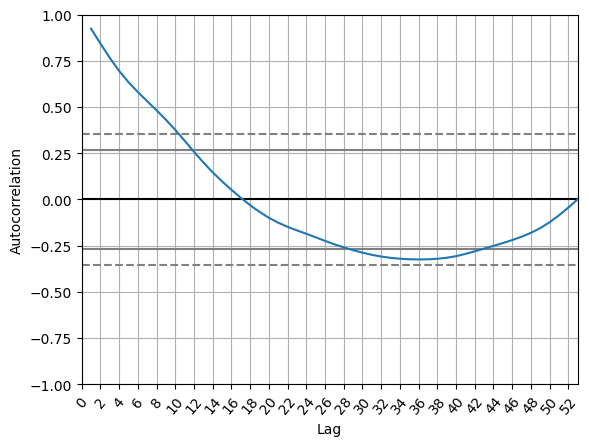

In [36]:
autocorrelation_plot(y_train)
# Adjust rotation
plt.xticks(range(0, len(y_train), 2), rotation=50)

In [37]:
#importing libraries for arima modeling
from statsmodels.tsa.arima.model import ARIMA

In [38]:
# Assuming y_train is your time series data
# Define a list of possible (p, d, q) combinations to test
parameter_combinations = [
    (0, 0, 0), (1, 0, 0), (2, 0, 0),
    (0, 1, 0), (1, 1, 0), (2, 1, 0),
    (0, 1, 1), (1, 1, 1), (2, 1, 1),
    (0, 2, 0), (1, 2, 0)
]

best_aic = np.inf  # Start with a very large AIC to track improvements
best_bic = np.inf  # Start with a very large BIC to track improvements
best_model = None  # To store the best model
best_order = None  # To store the best combination of (p, d, q)

# Loop over each combination and fit the ARIMA model
for p, d, q in parameter_combinations:
    print(f"Fitting ARIMA({p}, {d}, {q})...")

    # Create the ARIMA model with the current combination of parameters
    model = ARIMA(y_train, order=(p, d, q))

    # Fit the model to the data
    try:
        fitted_model = model.fit()

        # Get AIC and BIC for the current model
        aic = fitted_model.aic
        bic = fitted_model.bic

        # Check if the current model has better AIC/BIC than the previous best
        if aic < best_aic:
            best_aic = aic
            best_bic = bic
            best_model = fitted_model
            best_order = (p, d, q)

    except Exception as e:
        print(f"Error fitting ARIMA({p}, {d}, {q}): {e}")
        continue

# After the loop, print the best model's details
print(f"\nBest model is ARIMA{best_order} with AIC={best_aic} and BIC={best_bic}")
#print("\nSummary of the best model:")
#print(best_model.summary())

# Optionally, plot diagnostics for the best model
#best_model.plot_diagnostics(figsize=(12, 8))
#plt.show()

Fitting ARIMA(0, 0, 0)...
Fitting ARIMA(1, 0, 0)...
Fitting ARIMA(2, 0, 0)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Fitting ARIMA(0, 1, 0)...
Fitting ARIMA(1, 1, 0)...
Fitting ARIMA(2, 1, 0)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Fitting ARIMA(0, 1, 1)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Fitting ARIMA(1, 1, 1)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

Fitting ARIMA(2, 1, 1)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Fitting ARIMA(0, 2, 0)...
Fitting ARIMA(1, 2, 0)...

Best model is ARIMA(0, 2, 0) with AIC=956.3036933320516 and BIC=958.2355189647759


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              HomeValue   No. Observations:                   53
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -477.152
Date:                Sat, 30 Nov 2024   AIC                            956.304
Time:                        21:23:36   BIC                            958.236
Sample:                             0   HQIC                           957.042
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.652e+06   1.07e+06      7.171      0.000    5.56e+06    9.74e+06
Ljung-Box (L1) (Q):                  23.40   Jarque-Bera (JB):                 9.36
Prob(Q):                              0.00   Pr

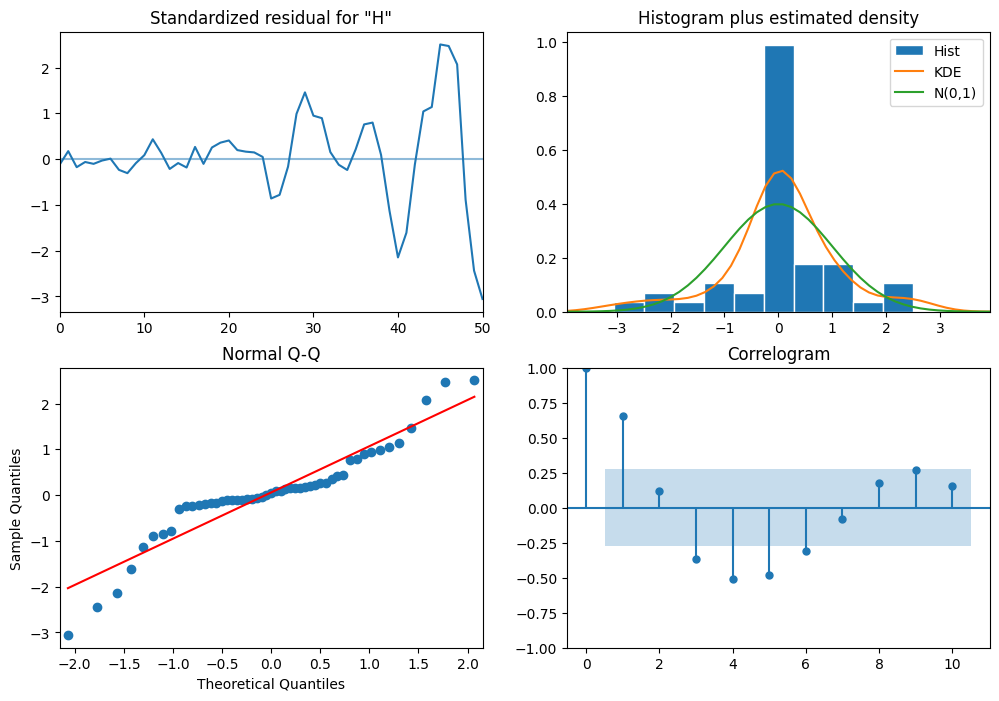

In [39]:
#The seasonal order is denoted by (P, D, Q, m)
order = (0, 2, 0)

#ARIMA model object
model = ARIMA(y_train, order=order)

#fit the model to the data
fitted_model = model.fit()

#print model's summary
print(fitted_model.summary())

#plot
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

Now we us the model to forecast future values of the time series. Forecasted values are the predicted values of the time series

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predictions:
 2022-07-01    9.230767e+05
2022-08-01    9.333315e+05
2022-09-01    9.435863e+05
2022-10-01    9.538412e+05
2022-11-01    9.640960e+05
2022-12-01    9.743508e+05
2023-01-01    9.846056e+05
2023-02-01    9.948605e+05
2023-03-01    1.005115e+06
2023-04-01    1.015370e+06
2023-05-01    1.025625e+06
2023-06-01    1.035880e+06
2023-07-01    1.046135e+06
2023-08-01    1.056389e+06
2023-09-01    1.066644e+06
2023-10-01    1.076899e+06
2023-11-01    1.087154e+06
2023-12-01    1.097409e+06
2024-01-01    1.107664e+06
2024-02-01    1.117918e+06
2024-03-01    1.128173e+06
2024-04-01    1.138428e+06
2024-05-01    1.148683e+06
Name: predicted_mean, dtype: float64
Actual values (y_test):
 2022-07-01    913153.036869
2022-08-01    904947.747440
2022-09-01    891490.618975
2022-10-01    879394.082138
2022-11-01    870207.266855
2022-12-01    863423.863265
2023-01-01    856145.497995
2023-02-01    850919.128367
2023-03-01    849092.604725
2023-04-01    852290.137006
2023-05-01    859129.84

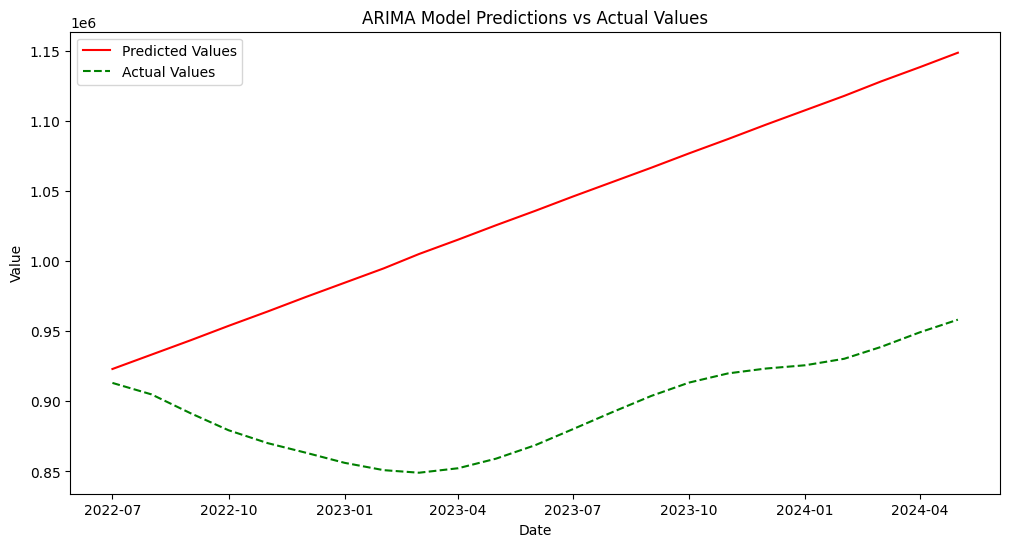

In [40]:
# Extract the dates from the first column of X_test
dates = X_test.iloc[:, 0].map(pd.Timestamp.fromordinal).values

# Generate predictions for the same range as X_test
start = len(y_train)
end = start + len(X_test) - 1
predictions = fitted_model.predict(start=start, end=end)

# Align predictions with dates from X_test
predictions.index = dates
y_test.index = dates

# Print predictions and y_test for verification
print("Predictions:\n", predictions)
print("Actual values (y_test):\n", y_test)

# Plot predictions vs actual values with dates on the x-axis
plt.figure(figsize=(12, 6))

# Plot the predicted values
plt.plot(dates, predictions, label='Predicted Values', color='red')

# Plot the actual values from y_test
plt.plot(dates, y_test, label='Actual Values', color='green', linestyle='--')

# Add labels, title, and legend for clarity
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.legend()

# Show the plot
plt.show()

ARIMA shows to have effective modelling with this small data set that we are attempting to forcast data with a small period of historical data.

In the graph with historical predictions, the graph displays that the values will not just increase. For the most part the home values holds it's stability in cost but over time it doesn't rapidly increase as the model shows above.

The seems to be more external values that may be affecting the homevalue that we don't see in this model.



---



# 3. Random Forest

 I lowered the ammount of  n_estimators due to it being a univariant dataset. It being less complex means that it needs less decision tree's
  - Reference : https://www.ine.pt/revstat/pdf/Randomforestsfortimeseries.pdf

  - https://stackoverflow.com/questions/67116078/random-forest-train-test-split-accuracy

  

In [42]:
#setting use of Random Forest Regressor
rf = RandomForestRegressor(n_estimators=10)

#train the model
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [43]:
#predict
y_pred_rf = rf.predict(X_test)

The variables weren't continuous so a confusion matrix isn't facilitate continuous predictions in Random Forest Regressor and so to get further understanding we will calculate MAE, MSE, RMSE and R2

In [44]:
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Mean Absolute Error: 29766.26072138556
Mean Squared Error: 1208863160.9756393
Root Mean Squared Error: 34768.70950978249
R² Score: -0.12133371770559753


Testing alternative Hyperparameters

Random Forest Regressor Version 2

In [45]:
rf_2= RandomForestRegressor(n_estimators=100,)

#train the model
rf_2.fit(X_train, y_train)

RandomForestRegressor()

In [46]:
y_pred_rf_2 = rf_2.predict(X_test)

In [47]:
# Calculate regression metrics
mae_2 = mean_absolute_error(y_test, y_pred_rf_2)
mse_2 = mean_squared_error(y_test, y_pred_rf_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test, y_pred_rf_2)

print("Mean Absolute Error Version 2:", mae_2)
print("Mean Squared Error Version 2:", mse_2)
print("Root Mean Squared Error Version 2:", rmse_2)
print("R² Score Version 2:", r2_2)

Mean Absolute Error Version 2: 29471.447086498378
Mean Squared Error Version 2: 1179681892.455098
Root Mean Squared Error Version 2: 34346.49752820654
R² Score Version 2: -0.09426536011655906


Random Forest Regressor Version 3 via a Grid Search CV

In [48]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [49]:
#retraining the model based on the best parameters from gridsearch from above
#Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
rf_3 = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)

#train the model
rf_3.fit(X_train, y_train)

#predict
y_pred_rf_3 = rf_3.predict(X_test)

#print
print(y_pred_rf_3)

[904337.02169204 904337.02169204 904337.02169204 904337.02169204
 904337.02169204 904337.02169204 904337.02169204 904337.02169204
 904337.02169204 904337.02169204 904337.02169204 904337.02169204
 904337.02169204 904337.02169204 904337.02169204 904337.02169204
 904337.02169204 904337.02169204 904337.02169204 904337.02169204
 904337.02169204 904337.02169204 904337.02169204]


In [50]:
# Calculate regression metrics
mae_3 = mean_absolute_error(y_test, y_pred_rf_3)
mse_3 = mean_squared_error(y_test, y_pred_rf_3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test, y_pred_rf_3)

print("Mean Absolute Error Version 2:", mae_3)
print("Mean Squared Error Version 2:", mse_3)
print("Root Mean Squared Error Version 2:", rmse_3)
print("R² Score Version 2:", r2_3)

Mean Absolute Error Version 2: 29273.27390214965
Mean Squared Error Version 2: 1157713318.877615
Root Mean Squared Error Version 2: 34025.18653699954
R² Score Version 2: -0.07388745211376557


I wouldnt say that modeling through Random Forest is a good idea because the multi predictions that ARIMA modelling provides multiple future predictions compared to the one with Random Forest modeling.

It would be best to use random Forest modelling when there is more than one variable for imput. With the data being univariant this provides limits to the modeling.

Also, it would be better to efficiently on larger databases.

With the score = -.10 and -.07 I'd say that it's pretty bad because it is less accurate.



---



# 4. XGBoost




This is gradient-boosted decision tree that is scaleable. It's an ensemble learning algorithim for classification and regression.

This includes bagging, boosting and gradient boosting ensemble technique.
  - Ensemble learning uses two or more learners.
  - Bagging uses a technique called bootstrap resampling to derive multiple new datasets from one initial training dataset in order to train multiple base learners.
  - Boosting combines multiple weaker classifers to create a stonger classifer.



In [52]:
xgb.XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [53]:
#setting the matrix
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

#parameters
params = {'objective': 'reg:squarederror'}

#XGBoost model
model_xgb = xgb.train(params, dtrain)

#predictions from the test set
predictions_xgb = model_xgb.predict(dtest)

#calculate the regression
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mse)
r2_xgb = r2_score(y_test, predictions_xgb)


print(f'Mean Absolute Error: {mse_xgb}')
print(f'Mean Squared Error: {mae_xgb}')
print(f'Root Mean Squared Error: {mae_xgb}')
print(f'R Squared : {r2_xgb}')

Mean Absolute Error: 1255683793.4159882
Mean Squared Error: 29965.081302239945
Root Mean Squared Error: 29965.081302239945
R Squared : -0.16476423617494285


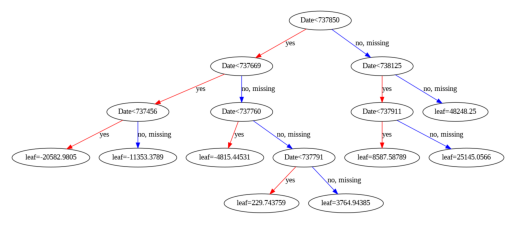

In [54]:
#plotting xgb

plot_tree(model_xgb)
plt.show()

Checking the shape for hyperparameter tuning for XGBoost

In [55]:
print(X_train.shape)
print(y_train.shape)

(53, 1)
(53,)


In [56]:
y_train = y_train.ravel()

<ipython-input-56-fa8dd90debe1>:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()


In [61]:
#hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

#XGBoost model object
xgb_model = xgb.XGBRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

#GridSearchCV object
grid_search.fit(X_train, y_train)

#print
print(f"Best set of hyperparameters: {grid_search.best_params_} ")
print(f"Best score (negative MSE): {grid_search.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best set of hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100} 
Best score (negative MSE): -2525820905.3814917


In [58]:
best_params = grid_search.best_params_

#train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

#make predictions
y_pred = best_xgb_model.predict(X_test)

#evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 31043.695208391146
Mean Squared Error (MSE): 1377804965.5159545
R² Score: -0.27804305245626715


The best score presents a negative mean squared error which is to maximize the score.

1,377,804,965.51 is the average squared error between predicted and the value. With the best score being so large it indicated the models predictions are extremely far from the true value.  

The calculation of the regression indicaties that this models preformance isn't fitting well. I believe the model is too complex for the univariant data of the property sold in San Diego from 2018 to 2024. This model most likely needs more dimenstion from the data.



---



# Comparing Models

Linear Regression: -1474041519.440787 (564372087.849245)
Random Forest: -27084524.900764 (15173350.286809)
XGBoost: -91635619.598751 (43387485.369986)


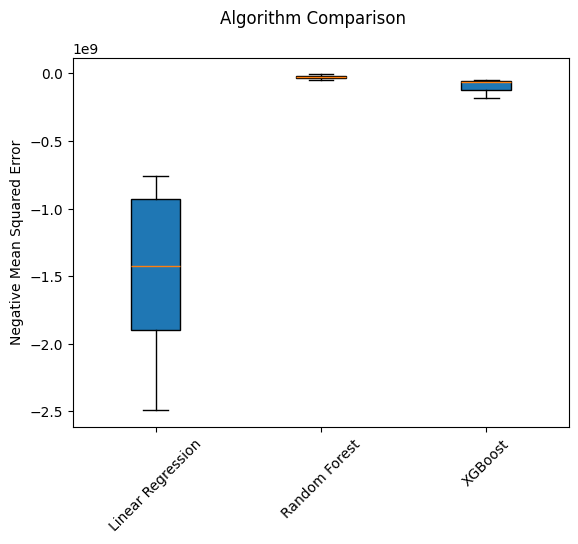

(76, 1)
(76,)
float64


In [59]:
#comparing the modeling
models_2 = []
models_2.append(('Linear Regression', LinearRegression()))
models_2.append(('Random Forest', RandomForestRegressor(random_state=42)))
models_2.append(('XGBoost', XGBRegressor(random_state=42)))

results = []
names = []
scoring = 'neg_mean_squared_error'
seed = 42

for name, model_2 in models_2:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model_2, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

#boxplot alg
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, vert=True, patch_artist=True)
ax.set_xticklabels(names, rotation=45)
ax.set_ylabel('Negative Mean Squared Error')
plt.show()


#checking due to valueError: continuous not supported
print(X.shape)
print(y.shape)
print(y.dtype)

While creating a section to compare all the models, I ran into issues demonstrating ARIMA model so I decided to create a short demonstration below the other three to easily compare the Three models vs One model.



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

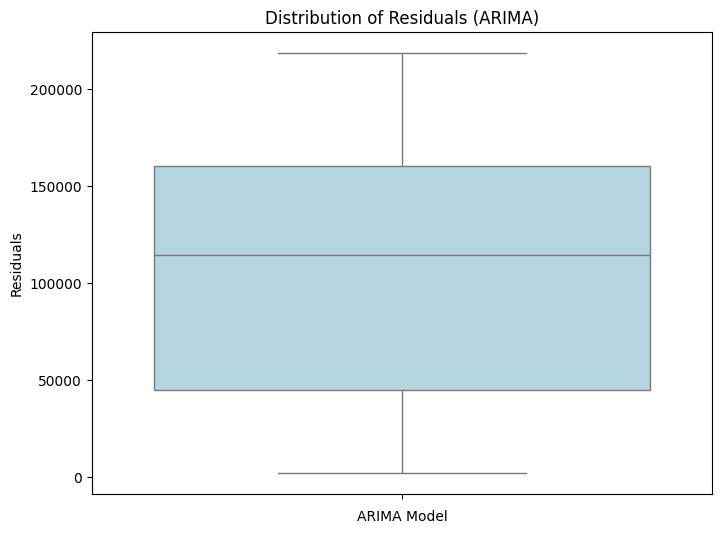

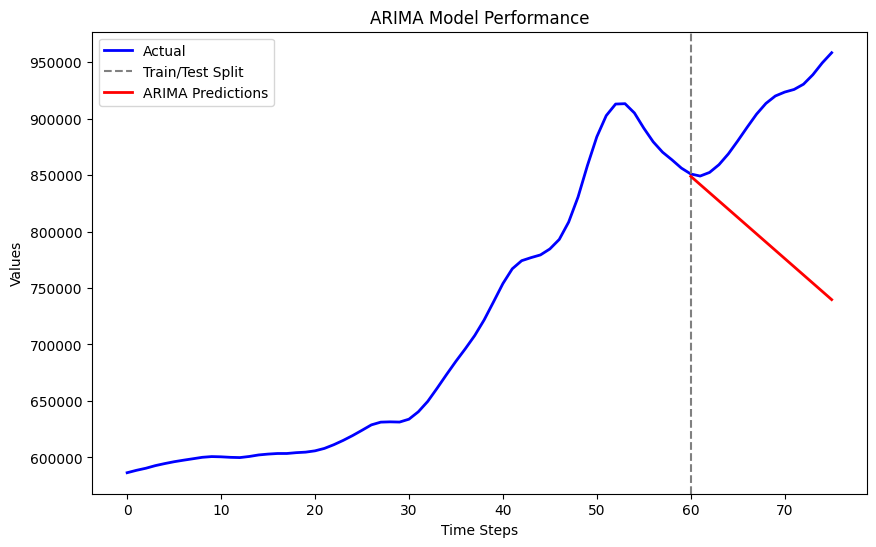

In [66]:
#Viewing ARIMA to compare to models above

train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

p, d, q = 0, 2, 0

#fit ARIMA model
model = ARIMA(train, order=(p, d, q))
arima_model = model.fit()


predictions = arima_model.forecast(steps=len(test))
test = np.array(test)
predictions = np.array(predictions)
residuals = test - predictions

#forecast
#predictions = arima_model.forecast(steps=len(test))
#mse = mean_squared_error(test, predictions)
#print(f"ARIMA Mean Squared Error: {mse}")
#residuals_2 = test - predictions

#boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y=residuals, color='lightblue')
plt.title('Distribution of Residuals (ARIMA)')
plt.ylabel('Residuals')
plt.xlabel('ARIMA Model')
plt.show()

#graphing the ARINA model to visualize the proformance
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label='Actual', color='blue', linewidth=2)
plt.axvline(x=train_size, color='gray', linestyle='--', label='Train/Test Split')
plt.plot(range(train_size, len(y)), predictions, label='ARIMA Predictions', color='red', linewidth=2)
plt.title('ARIMA Model Performance')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()



---



# Conclusion

Analyzing home values in San Diego from 2018 to 2024, this study aims to compare predicted values with actual values to determine whether homes in California can sustain their value. The ultimate goal is to assess whether purchasing a home in California is a worthwhile investment. Among various modeling techniques, I initially preferred ARIMA for its effectiveness in handling univariate time series datasets.

The ARIMA model indicates that while a property can maintain its value as a family home—making it a worthwhile purchase—it may not provide the stability desired for investment purposes.

To evaluate the investment potential of home values in California, particularly in San Diego, it is essential to collect and analyze external variables that may influence property prices.

When examining the progression of property values through the time series, ARIMA modeling reveals that San Diego home values underperform compared to predicted values. In contrast, Linear Regression modeling shows greater promise in accurately tracking actual values. Initially, I considered ARIMA to be the most accurate model for predictions. However, upon further review, I concluded that Linear Regression better represents the relationship between predictive and actual home values.

Notably, there is a price drop around January 2023, followed by a recovery, with prices surpassing predictions entirely by 2024.

Although I initially appreciated the modeling capabilities of ARIMA, I now believe that Linear Regression provides a better representation of both predictive and actual values.

Based on this analysis, I conclude that San Diego remains a promising investment opportunity.